# Linear Mixed Model

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm 
import statsmodels.formula.api as smf

random_state = 42

## Function definitions

In [2]:
# Define a function to calculate the confidence interval
def calc_ci(x, params, cov_params, z=1.96, group=0):
    
    # Calculate the prediction and var cov
    if group==0:
        b0, m0 = params[:2]
        pred = b0 + m0 * x
        b0_var, m0_var = np.diag(cov_params)[:2]
        covb0m0 = cov_params[0,1]

        # Calculate the standard error of the prediction    
        pred_se = np.sqrt(b0_var + m0_var * x**2 + 
                          2 * x * covb0m0)
    else:
        b0, m0, b1, m1 = params[:4]
        pred = (b0 + b1) + (m0 + m1) * x
        b0_var, m0_var, b1_var, m1_var = np.diag(cov_params)[:4]    
        covb0m0 = cov_params[0,1]
        covb0b1 = cov_params[0,2]
        covb0m1 = cov_params[0,3]
        covm0b1 = cov_params[1,2]
        covm0m1 = cov_params[1,3]
        covb1m1 = cov_params[2,3]
    
        # Calculate the standard error of the prediction    
        pred_se = np.sqrt(
                      b0_var + b1_var + m0_var * x**2 + m1_var * x**2 + 
                      2 * covb0b1 + 
                      2 * x * covb0m0 + 2 * x * covb0m1 + 
                      2 * x * covm0b1 + 2 * x * covb1m1 + 
                      2 * x**2 * covm0m1
                    )

    # Calculate the confidence interval
    ci_lower = pred - z * pred_se
    ci_upper = pred + z * pred_se
    return ci_lower, ci_upper

def plot_regression_line(x, params, cov_params, axs,color, z=1.96, label = None, group=0):

    # Calculate the prediction
    if group==0:
        b0, m0 = params[:2]
        pred = b0 + m0 * x
    else:
        b0, m0, b1, m1 = params[:4]
        pred = (b0 + b1) + (m0 + m1) * x    
    
    # Plot the regression lines
    axs.plot(x, 
            pred, 
            color = color, 
            lw = 4, 
            label=label
        )

    # Calculate the confidence intervals
    ci_lower, ci_upper = calc_ci(x, params, cov_params, z=z, group=group)    
    
    # Plot the confidence intervals
    axs.fill_between(x, ci_lower, 
                     ci_upper,
                        color=color, 
                        alpha=0.2)

In [3]:
def LMM_all(users_sample,adjust = 'both',independent_variable = 'years_since_onset',dependant_variable = 'ratings_slp_11',
           grouping_variable = None,order = 'linear', start_params=None):
    if grouping_variable is None:
        model_expresion = f'{dependant_variable} ~ {independent_variable}'
        if order != 'linear':
            model_expresion += f' + I({independent_variable}**2)'

    else:
        model_expresion = f'{dependant_variable} ~ {independent_variable}*{grouping_variable}'
        if order != 'linear':
            model_expresion += f' + I({independent_variable}**2)*{grouping_variable}'

    if adjust == 'both':
        re_formula = f'1 + {independent_variable}'

    model = smf.mixedlm(model_expresion,
                        data=users_sample, 
                        groups=users_sample["user_id"],
                        re_formula=re_formula)

    if start_params is None:
        model_fit = model.fit()
    else: 
        model_fit = model.fit(start_params=start_params)
    return model_fit


In [4]:
def se_from_var_cov(model_fit,var1,var2):
    a =  model_fit.cov_params().loc[var1,var1]
    b =  model_fit.cov_params().loc[var2,var2]
    c =  model_fit.cov_params().loc[var1,var2]
    # c=0
    return np.sqrt(a+b+2*c)

def plot_LMM_all(model_fit, users_sample, adjust = 'both',independent_variable = 'years_since_onset',dependant_variable = 'ratings_slp_11',
           grouping_variable = None, order = 'linear',labels=['pALS','Ctrl'],timeunits='Months', axs=None, colors=None):
    if colors is None:
        colors = sns.color_palette()
    if timeunits=='Months':
        timescale = 1/12
    else:
        timescale = 1 
    if grouping_variable is not None and order=='quadratic':
        print('Ojo, cuadratico y grupo no plotea la incerteza. OJO.')
    
    re = model_fit.random_effects

    if axs == None:
        fig, axs = plt.subplots(1, 1, figsize=(4, 3))

    for i, user_id in enumerate(users_sample.user_id.unique()):
        df_user = users_sample[users_sample.user_id == user_id]
        x = df_user[independent_variable]
        x /= timescale
        y = df_user[dependant_variable]
        
        fixed_intercept = model_fit.params['Intercept']
        fixed_slope = model_fit.params[independent_variable]

        if order != 'linear':
            fixed_quad = model_fit.params[f'I({independent_variable} ** 2)']
        else:
            fixed_quad = 0

        var_slope = model_fit.random_effects_cov[user_id][independent_variable][independent_variable]
        var_intercept = model_fit.random_effects_cov[user_id]['Group']['Group']

        if grouping_variable is not None:
            if df_user[grouping_variable].iloc[0] == 1:
                fixed_intercept += model_fit.params[f'{grouping_variable}']
                fixed_slope += model_fit.params[f'{independent_variable}:{grouping_variable}']

        # Efectos aleatorios para este user_id
        random_intercept = re[user_id]['Group']
        random_slope = re[user_id][independent_variable]

        slope = fixed_slope + random_slope
        slope *= timescale
        
        intercept = fixed_intercept + random_intercept

        x_plot = np.linspace(x.min(),x.max(),11)

        if grouping_variable is None:
            color = colors[1]
        else:
            color  = colors[1] if df_user[grouping_variable].iloc[0] == 1 else colors[0]

        axs.scatter(x, y, s = 4, color=color, alpha=0.2)
        
        axs.plot(x_plot, intercept + slope*x_plot + fixed_quad * x_plot ** 2, color = color, alpha = 0.2)

    if True:

        if grouping_variable is None:
            color = colors[1]
        else:
            color = colors[0]

        x_plot = np.linspace(min(0,users_sample[independent_variable].min()), 
                             users_sample[independent_variable].max(), 100)

        x_plot /= timescale

        if order == 'linear':
            params = model_fit.params.values[:4]
            cov_params = model_fit.cov_params().iloc[:4,:4].values
            plot_regression_line(x_plot, params, cov_params, axs,color, z=1.96, label=labels[0], group=0)   

            if grouping_variable is not None:   
                
                params = model_fit.params.values[:4]
                cov_params = model_fit.cov_params().iloc[:4,:4].values
                plot_regression_line(x_plot, params, cov_params, axs, colors[1], z=1.96, label=labels[1], group=1)   
            
        else: #quadratic
            intercept_controls, slope_controls = model_fit.params['Intercept'], model_fit.params[independent_variable]
            quad_controls = model_fit.params[f'I({independent_variable} ** 2)']
            quad_controls *= timescale**2
            axs.plot(x_plot, 
                    intercept_controls + slope_controls * x_plot + quad_controls * x_plot**2, 
                    color = color, lw = 4, label=labels[0])            

            if grouping_variable is not None:   
                quad_patients = quad_controls + model_fit.params[f'I({independent_variable} ** 2):{grouping_variable}']*timescale **2
                                
                intercept_patients = intercept_controls + model_fit.params[f'{grouping_variable}']
                slope_patients = slope_controls + model_fit.params[f'{independent_variable}:{grouping_variable}']*timescale
                axs.plot(x_plot, 
                    intercept_patients + slope_patients * x_plot + quad_patients * x_plot**2, 
                    color = colors[1], lw = 4, label=labels[1])  
                
        axs.legend()

    if independent_variable == 'years_since_first_session':
        axs.set_xlabel(f'{timeunits} since first session')
    elif independent_variable == 'years_since_onset':
        axs.set_xlabel(f'{timeunits} since onset')
    elif independent_variable == 'years_since_diagnosis':
        axs.set_xlabel(f'{timeunits} since diagnosis')

    if dependant_variable=='mean_':
        axs.set_ylabel('Listener Effort')
        axs.set_ylim(-5,105)
    elif dependant_variable=='alsfrsr':
        axs.set_ylabel('ALSFRS-R')
        axs.set_ylim(0,48)
    elif dependant_variable=='bulbar':
        axs.set_ylabel('ALSFRS-R bulbar')
        axs.set_ylim(0,12.5)
    elif dependant_variable=='alsfrsr_1':
        axs.set_ylabel('ALSFRS-R 1')
        axs.set_ylim(0,4.2)
    else:
        axs.set_ylabel(dependant_variable)
    
def table_summary(model_fit, users_sample, adjust = 'both',independent_variable = 'years_since_onset',dependant_variable = 'ratings_slp_11',
           grouping_variable = None, order = 'linear',labels=['pALS','Ctrl'],timeunits='Months'):
    if timeunits=='Months':
        timescale = 1/12
    else:
        timescale = 1 
    intercept_controls, slope_controls = model_fit.params['Intercept'], model_fit.params[independent_variable]
    intercept_se_controls, slope_se_controls = model_fit.bse['Intercept'], model_fit.bse[independent_variable]
    slope_controls *= timescale
    slope_se_controls *= timescale    
    
    t = f'Population\tIntercept (SE)\tSlope (SE) (1/{timeunits})'
    t += f'\n{labels[0]}\t{intercept_controls:.1f} ({intercept_se_controls:.1f})\t{slope_controls:.1f} ({slope_se_controls:.1f})'
    if grouping_variable is not None:
        intercept_patients = intercept_controls + model_fit.params[f'{grouping_variable}']
        slope_patients = slope_controls + model_fit.params[f'{independent_variable}:{grouping_variable}']*timescale
        intercept_se_patients = se_from_var_cov(model_fit,'Intercept',grouping_variable)
        slope_se_patients = se_from_var_cov(model_fit,independent_variable,f'{independent_variable}:{grouping_variable}')
        slope_se_patients *= timescale
        t += f'\n{labels[1]}\t{intercept_patients:.1f} ({intercept_se_patients:.1f})\t{slope_patients:.1f} ({slope_se_patients:.1f})'
        
        intercept_interaction = model_fit.params[f'{grouping_variable}']
        slope_interaction = model_fit.params[f'{independent_variable}:{grouping_variable}']*timescale  
        intercept_se_interaction = model_fit.bse[f'{grouping_variable}']
        slope_se_interaction = model_fit.bse[f'{independent_variable}:{grouping_variable}']
        t += f'\nInteraction\t{intercept_interaction:.1f} ({intercept_se_interaction:.1f})\t{slope_interaction:.1f} ({slope_se_interaction:.1f})'

    return t

In [5]:
def CoV(model_fit,indep_var='years_since_onset'):    
    re_values = [value[indep_var] for key,value in model_fit.random_effects.items()]
    CoV = np.std(re_values,ddof=1) / model_fit.fe_params[indep_var]
    print('std:',np.std(re_values,ddof=1), 'mean:',model_fit.fe_params[indep_var])
    return CoV

def plot_controls(df_turns_usable, independent_variable, dependant_variable):
    for i, user_id in enumerate(df_turns_usable.query('not pat').user_id.unique()):
        df_user = df_turns_usable[df_turns_usable.user_id == user_id]
        x = df_user[independent_variable]
        y = df_user[dependant_variable]

        x_plot = np.linspace(x.min(),x.max(),11)

        color = sns.color_palette()[0]

        if dependant_variable!='alsfrsr_1':
            plt.scatter(x, y, s = 4, color=color, alpha=0.2)

In [6]:
def fcn_lmm_all_conditions(users_sample,independent_variable,dependant_variable,grouping_variable,labels,axs,verbose):
    plt.sca(axs)
    adjust = 'both'
    order = 'linear'
    timeunits = 'years'
    
    model_fit = LMM_all(users_sample,adjust,independent_variable,dependant_variable,
               grouping_variable,order,start_params=None)
    if not model_fit.converged:
        print('No convergio, va de nuevo',model_fit.params.values)
        model_fit = LMM_all(users_sample,adjust,independent_variable,dependant_variable,
               grouping_variable,order,start_params=model_fit.params)
    if not model_fit.converged:
        print('No convergio, va de nuevo',model_fit.params.values)
        model_fit = LMM_all(users_sample,adjust,independent_variable,dependant_variable,
               grouping_variable,order,start_params=model_fit.params)
    if verbose:
        print(model_fit.summary())
        print(table_summary(model_fit, users_sample,adjust,independent_variable,dependant_variable,
               grouping_variable,order,labels,timeunits=timeunits))
    colors = [sns.color_palette()[4], sns.color_palette()[3]]
    # colors = [sns.color_palette()[0], sns.color_palette()[1]]
    plot_LMM_all(model_fit, users_sample,adjust,independent_variable,dependant_variable,
               grouping_variable,order,labels,timeunits=timeunits,colors=colors,axs=axs)

    if independent_variable == 'years_since_first_session':
        ax = plt.gca()    
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: str(int(12*x))))
        plt.xlabel('Months since enrollment')
        plt.xlim(0,2)
    else:
        plt.xlabel('Years since onset')        
        plt.xlim(0,25)

    if dependant_variable == 'speaking_rate_mean_wpm':
        plt.ylim([0,300])
        plt.ylabel('Speaking rate (words/min)')
    elif dependant_variable == 'effort_mean':
        plt.ylim([0,100])
        # plt.ylim([-30,60])
        plt.ylabel('Listener Effort')
    elif dependant_variable == 'articulation_rate_mean':
        plt.ylim([0,6])
        plt.ylabel('Articulation rate (syl/s)')
    elif dependant_variable == 'alsfrsr':
        plt.ylim([0,50])
        plt.ylabel('ALSFRS-R')
    elif dependant_variable == 'alsfrsr_1':
        plt.ylim([0,4.3])
        plt.ylabel('ALSFRS-R Q1')
    plt.legend(loc='upper right')
                
def fcn_lmm_all_conditions_ctr_pac(df_pac,df_ctrl,independent_variable,dependant_variable,axs,verbose,returnmodels=False,plotcontrols=True):
    plt.sca(axs)    
    adjust = 'both'
    order = 'linear'
    timeunits = 'years'    
    
    ### PAC
    grouping_variable,labels = None,[f'pALS (n={df_pac.user_id.nunique()})']
    model_fit = LMM_all(df_pac,adjust,independent_variable,dependant_variable,
               grouping_variable,order,start_params=None)
    if not model_fit.converged:
        print('No convergio, va de nuevo',model_fit.params.values)
        model_fit = LMM_all(df_pac,adjust,independent_variable,dependant_variable,
               grouping_variable,order,start_params=model_fit.params)
    if not model_fit.converged:
        print('No convergio, va de nuevo',model_fit.params.values)
        model_fit = LMM_all(df_pac,adjust,independent_variable,dependant_variable,
               grouping_variable,order,start_params=model_fit.params)
    if verbose:
        print(model_fit.summary())
        print('CoV slope:' ,CoV(model_fit,independent_variable))
        print(table_summary(model_fit, df_pac,adjust,independent_variable,dependant_variable,
                   grouping_variable,order,labels,timeunits=timeunits))
    plot_LMM_all(model_fit, df_pac,adjust,independent_variable,dependant_variable,
               grouping_variable,order,labels,timeunits=timeunits,axs=axs)
    model_fit_pals = model_fit
    
    ### CTRL
    grouping_variable,labels = None,['Ctrl']
    model_fit = LMM_all(df_ctrl,adjust,independent_variable,dependant_variable,
               grouping_variable,order,start_params=None)
    if not model_fit.converged:
        print('No convergio, va de nuevo',model_fit.params.values)
        model_fit = LMM_all(df_ctrl,adjust,independent_variable,dependant_variable,
               grouping_variable,order,start_params=model_fit.params)
    if not model_fit.converged:
        print('No convergio, va de nuevo',model_fit.params.values)
        model_fit = LMM_all(df_ctrl,adjust,independent_variable,dependant_variable,
               grouping_variable,order,start_params=model_fit.params)
    model_fit_ctrl = model_fit
    if verbose:        
        print(model_fit.summary())
        print('CoV slope:' ,CoV(model_fit,independent_variable))
        print(table_summary(model_fit, df_ctrl,adjust,independent_variable,dependant_variable,
                   grouping_variable,order,labels,timeunits=timeunits))
    if plotcontrols:
        plot_controls(df_ctrl, independent_variable, dependant_variable)
        params = model_fit.params.values[:4]
        cov_params = model_fit.cov_params().iloc[:4,:4].values
        x_plot = np.linspace(plt.xlim()[0],plt.xlim()[1],100)
        axs =plt.gca()
        plot_regression_line(x_plot, params, cov_params, axs,sns.color_palette()[0], z=1.96, label=f'Controls (n={df_ctrl.user_id.nunique()})') 
    
    if independent_variable == 'years_since_first_session':
        ax = plt.gca()    
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: str(int(12*x))))
        plt.xlabel('Months since enrollment')
        plt.xlim(0,2)
    else:
        plt.xlabel('Years since onset')
        plt.xlim(0,25)

    if dependant_variable == 'speaking_rate_mean_wpm':
        plt.ylim([0,300])
        plt.ylabel('Speaking rate (words/min)')
    elif dependant_variable == 'effort_mean':
        plt.ylim([0,100])
        # plt.ylim([-30,60])
        plt.ylabel('Listener Effort')
    elif dependant_variable == 'articulation_rate_mean':
        plt.ylim([0,6])
        plt.ylabel('Articulation rate (syl/s)')
    elif dependant_variable == 'alsfrsr':
        plt.ylim([0,50])
        plt.ylabel('ALSFRS-R')
    elif dependant_variable == 'alsfrsr_1':
        plt.ylim([0,4.3])
        plt.ylabel('ALSFRS-R 1')
    elif dependant_variable == 'bulbar':
        plt.ylim([0,12.3])
        plt.ylabel('ALSFRS-R Bulbar')
    plt.legend(loc='upper right')            
            
    if returnmodels:
        return model_fit_pals,model_fit_ctrl

## Load data

In [7]:
df_turns_usable = pd.read_csv('fig_4.csv')

CTRL vs PAC, years since onset
                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       effort_mean
No. Observations:       552           Method:                   REML       
No. Groups:             105           Scale:                    15.5468    
Min. group size:        1             Log-Likelihood:           -1927.5577 
Max. group size:        13            Converged:                Yes        
Mean group size:        5.3                                                
---------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------
Intercept                       -4.886    3.466 -1.410 0.159 -11.680  1.908
years_since_onset                9.292    1.814  5.123 0.000   5.737 12.848
Group Var                      667.785   50.879                            


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     effort_mean
No. Observations:       119         Method:                 REML       
No. Groups:             20          Scale:                  1.0214     
Min. group size:        2           Log-Likelihood:         -192.6686  
Max. group size:        10          Converged:              Yes        
Mean group size:        6.0                                            
-----------------------------------------------------------------------
                              Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                      1.746    0.327 5.345 0.000  1.106  2.386
years_since_onset              0.059    0.240 0.244 0.807 -0.412  0.529
Group Var                      1.672    0.736                          
Group x years_since_onset Cov -0.049    0.406                          
years_sin

/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        effort_mean
No. Observations:         119            Method:                    REML       
No. Groups:               20             Scale:                     1.0214     
Min. group size:          2              Log-Likelihood:            -192.6686  
Max. group size:          10             Converged:                 Yes        
Mean group size:          6.0                                                  
-------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------------------
Intercept                              1.746    0.327 5.345 0.000  1.106  2.386
years_since_first_session              0.059    0.240 0.244 0.807 -0.412  0.529
Group Var                              1.672    0.736        

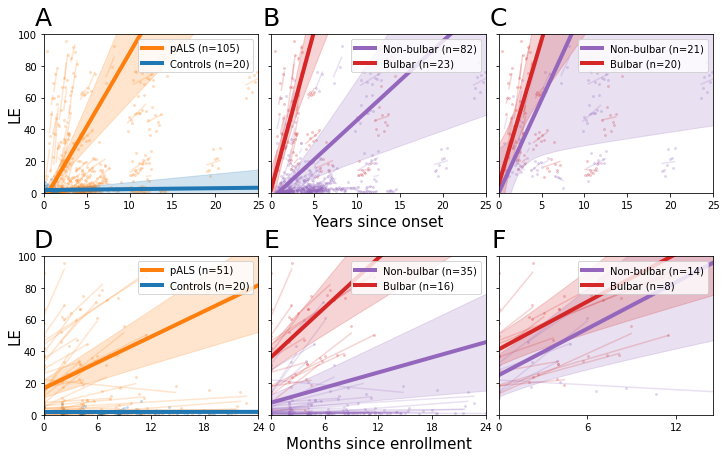

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
plt.subplots_adjust(wspace=0.06,hspace=0.4)
verbose = True

print('CTRL vs PAC, years since onset')
independent_variable = 'years_since_onset'
dependant_variable = 'effort_mean'
df_pac  = df_turns_usable.query('pat').copy()
df_ctrl  = df_turns_usable.query('not pat').copy()
fcn_lmm_all_conditions_ctr_pac(df_pac,df_ctrl,independent_variable,dependant_variable,axs[0][0],verbose)
plt.text(x=0,y=110,va='center',ha='center',s='A',fontsize=25)
plt.xlabel('')
plt.ylabel('LE',fontsize=15)
plt.gca().yaxis.set_label_coords(-0.1,0.5)

print('Bulbar-non bulbar, years since onset')
users_sample  = df_turns_usable.query('pat').copy() 
independent_variable = 'years_since_onset'
dependant_variable = 'effort_mean'
grouping_variable,labels = 'site_of_onset_bulbar',['Non-bulbar','Bulbar'] # can be an existing variable or None
n_non_bulbar, n_bulbar = users_sample.groupby('user_id').first().site_of_onset_bulbar.value_counts().to_list()
labels = [f'Non-bulbar (n={n_non_bulbar})',f'Bulbar (n={n_bulbar})']
fcn_lmm_all_conditions(users_sample,independent_variable,dependant_variable,grouping_variable,labels,axs[0][1],verbose)
plt.text(x=0,y=110,va='center',ha='center',s='B',fontsize=25)
plt.yticks(color='None')
plt.ylabel('')
plt.xlabel('Years since onset',fontsize=15)

print('Bulbar-non bulbar symptomatic, years since onset')
users_sample  = df_turns_usable.query('pat and  first_session_more_than_10==1').copy() 
independent_variable = 'years_since_onset'
dependant_variable = 'effort_mean'
grouping_variable,labels = 'site_of_onset_bulbar',['Non-bulbar','Bulbar'] # can be an existing variable or None
n_non_bulbar, n_bulbar = users_sample.groupby('user_id').first().site_of_onset_bulbar.value_counts().to_list()
labels = [f'Non-bulbar (n={n_non_bulbar})',f'Bulbar (n={n_bulbar})']
fcn_lmm_all_conditions(users_sample,independent_variable,dependant_variable,grouping_variable,labels,axs[0][2],verbose)
plt.text(x=0,y=110,va='center',ha='center',s='C',fontsize=25)
plt.yticks(color='None')
plt.ylabel('')
plt.xlabel('')

print('CTRL vs PAt, months since enrollment')
independent_variable = 'years_since_first_session'
dependant_variable = 'effort_mean'
uids2use = df_turns_usable.groupby('user_id')['years_since_onset'].min().to_frame().reset_index().query('years_since_onset < 3').user_id.values
df_pat = df_turns_usable.query('pat and user_id in @uids2use')
df_ctrl  = df_turns_usable.query('not pat').copy()
fcn_lmm_all_conditions_ctr_pac(df_pat,df_ctrl,independent_variable,dependant_variable,axs[1][0],verbose)
plt.text(x=0,y=110,va='center',ha='center',s='D',fontsize=25)
plt.xlabel('')
plt.ylabel('LE',fontsize=15)
plt.gca().yaxis.set_label_coords(-0.1,0.5)

print('Bulbar-non bulbar, months since enrollment')
uids2use = df_turns_usable.groupby('user_id')['years_since_onset'].min().to_frame().reset_index().query('years_since_onset < 3').user_id.values
users_sample = df_turns_usable.query('pat and user_id in @uids2use')
# users_sample  = df_turns_usable.query('pat').copy() 
independent_variable = 'years_since_first_session'
dependant_variable = 'effort_mean'
grouping_variable,labels = 'site_of_onset_bulbar',['Non-bulbar','Bulbar'] # can be an existing variable or None
n_non_bulbar, n_bulbar = users_sample.groupby('user_id').first().site_of_onset_bulbar.value_counts().to_list()
labels = [f'Non-bulbar (n={n_non_bulbar})',f'Bulbar (n={n_bulbar})']
fcn_lmm_all_conditions(users_sample,independent_variable,dependant_variable,grouping_variable,labels,axs[1][1],verbose)
plt.text(x=0,y=110,va='center',ha='center',s='E',fontsize=25)
plt.yticks(color='None')
plt.ylabel('')
plt.xlabel('Months since enrollment',fontsize=15)

print('Bulbar-non bulbar symptomatic, months since enrollment')
uids2use = df_turns_usable.groupby('user_id')['years_since_onset'].min().to_frame().reset_index().query('years_since_onset < 3').user_id.values
users_sample = df_turns_usable.query('pat and user_id in @uids2use and first_session_more_than_10==1')
independent_variable = 'years_since_first_session'
dependant_variable = 'effort_mean'
grouping_variable,labels = 'site_of_onset_bulbar',['Non-bulbar','Bulbar'] # can be an existing variable or None
n_non_bulbar, n_bulbar = users_sample.groupby('user_id').first().site_of_onset_bulbar.value_counts().to_list()
labels = [f'Non-bulbar (n={n_non_bulbar})',f'Bulbar (n={n_bulbar})']
fcn_lmm_all_conditions(users_sample,independent_variable,dependant_variable,grouping_variable,labels,axs[1][2],verbose)
plt.text(x=0,y=110,va='center',ha='center',s='F',fontsize=25)
plt.xlim([0,14.5/12])
plt.yticks(color='None')
plt.xticks(ticks=[0,6/12,12/12])
plt.ylabel('')
plt.xlabel('')

plt.show()

# Normal LE at baseline in PALS predicted participants likely to have slow progression. 

PALS LE < 10 at baseline


                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        effort_mean
No. Observations:          363            Method:                    REML       
No. Groups:                64             Scale:                     4.0494     
Min. group size:           2              Log-Likelihood:            -935.3219  
Max. group size:           13             Converged:                 Yes        
Mean group size:           5.7                                                  
--------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                               2.726    0.328 8.302 0.000  2.082  3.369
years_since_first_session               5.968    2.048 2.914 0.004  1.954  9.983
Group Var                               4.732    0

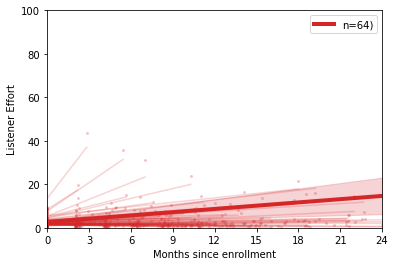

In [9]:
## En la seccion de resultado del paper no da otra slope!!

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

print('PALS LE < 10 at baseline')
users_sample = df_turns_usable.query('pat and first_session_more_than_10==0')
independent_variable = 'years_since_first_session'
dependant_variable = 'effort_mean'
grouping_variable, labels = None, None # can be an existing variable or None
labels = [f'n={users_sample.user_id.nunique()})']
fcn_lmm_all_conditions(users_sample, independent_variable,dependant_variable,grouping_variable,labels, axs, verbose)

PALS LE < 10 at baseline AND onset within the last 3 years


/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                     Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        effort_mean
No. Observations:          143            Method:                    REML       
No. Groups:                29             Scale:                     6.0861     
Min. group size:           2              Log-Likelihood:            -399.4534  
Max. group size:           12             Converged:                 Yes        
Mean group size:           4.9                                                  
--------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                               2.445    0.504 4.849 0.000  1.457  3.433
years_since_first_session              10.382    4.702 2.208 0.027  1.166 19.597
Group Var                               3.807    0

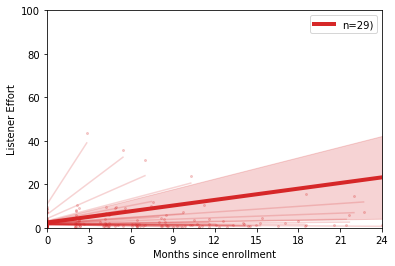

In [10]:
## Haciendo esta parte sola (sin interaccion) nos da igual al paper

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

print('PALS LE < 10 at baseline AND onset within the last 3 years')
uids2use = df_turns_usable.groupby('user_id')['years_since_onset'].min().to_frame().reset_index().query('years_since_onset < 3').user_id.values
users_sample = df_turns_usable.query('pat and user_id in @uids2use and first_session_more_than_10==0')
independent_variable = 'years_since_first_session'
dependant_variable = 'effort_mean'
grouping_variable, labels = None, None # can be an existing variable or None
labels = [f'n={users_sample.user_id.nunique()})']
fcn_lmm_all_conditions(users_sample, independent_variable,dependant_variable,grouping_variable,labels, axs, verbose)

PALS LE < 10 at baseline AND onset within the last 3 years
                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              effort_mean
No. Observations:              205                  Method:                          REML       
No. Groups:                    51                   Scale:                           11.1026    
Min. group size:               1                    Log-Likelihood:                  -695.6882  
Max. group size:               12                   Converged:                       Yes        
Mean group size:               4.0                                                              
------------------------------------------------------------------------------------------------
                                                      Coef.   Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
I

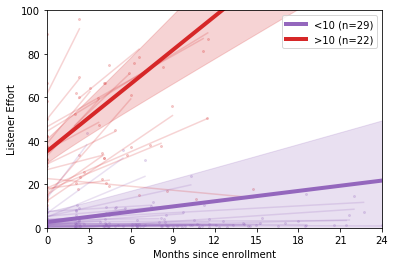

In [11]:
## Agregando interaccion, nos da un p NO SIGNIFICATIVO (que igual es bueno para nuestro argumento)
## 

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

print('PALS LE < 10 at baseline AND onset within the last 3 years')
uids2use = df_turns_usable.groupby('user_id')['years_since_onset'].min().to_frame().reset_index().query('years_since_onset < 3').user_id.values
users_sample = df_turns_usable.query('pat and user_id in @uids2use')
independent_variable = 'years_since_first_session'
dependant_variable = 'effort_mean'
grouping_variable, labels = 'first_session_more_than_10', ['False', 'True'] # can be an existing variable or None
n_false, n_true = users_sample.groupby('user_id').first().first_session_more_than_10.value_counts().to_list()
labels = [f'<10 (n={n_false})', f'>10 (n={n_true})']
fcn_lmm_all_conditions(users_sample, independent_variable,dependant_variable,grouping_variable,labels, axs, verbose)